In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import scipy.stats as sp
import matplotlib as mtp
#import PQ3_preprocessing as PQ3

# SCNA score quantification

In [2]:
Dir = "/cellar/users/a53206221/Data/PQ3RO1/tcga_pid.txt"
with open(Dir) as f:
    tcga_pid = [ x.replace("\n","") for x in f.readlines()]

In [3]:
len(tcga_pid)

9375

In [4]:
# THE BASIC BEFROE QUANTIFICATION : GET THE chr_baselength
def get_chr_baselength():
    chr_test_bp = pd.read_csv('~/Data/cnv_downloading/ref_chr.csv',sep='\t')
    chr_baselength = chr_test_bp[chr_test_bp.chromStart != 0][['chrom','chromEnd']]
    chr_baselength.chrom = [x[3:] for x in chr_baselength.chrom.tolist()]
    chr_baselength.rename(columns={'chrom':0},inplace=True)
    chr_baselength['Arm'] = chr_baselength.chromEnd/2

    hg38_cytobandfile = pd.read_csv('~/Data/GDC_CNV_counted/cytoBand.txt',sep='\t',header=None)
    tmp = hg38_cytobandfile[[True if x == 'p11.1' or x == 'q11' or x == 'p11' else False for x in hg38_cytobandfile[3].tolist()]]
    tmpp = tmp[tmp[3] == 'p11.1'][[0,2]]
    tmp1 = tmp[tmp[3] == 'q11'][[0,1]]
    tmp3 = tmp[tmp[3] =='p11'][[0,2]]
    tmp3.rename(columns={2:3},inplace=True)

    tmpttt = pd.merge(tmpp,tmp1, on = [0],how='outer')
    tmpttt = pd.merge(tmpttt,tmp3, on =[0],how = 'outer')
    value1 = {2:tmpttt[1]}
    value2 = {2:tmpttt[3]}
    tmpttt.fillna(value=value1,inplace=True)
    tmpttt.fillna(value=value2,inplace=True)
    hg_pqband = tmpttt.drop([1,3],axis = 1)
    hg_pqband[0] = [ x[3:] for x in hg_pqband[0].tolist()]


    chr_baselength = pd.merge(chr_baselength,hg_pqband, on = [0])
    chr_baselength.rename(columns={2:'q'},inplace=True)

    chr_baselength['q_len'] = chr_baselength.chromEnd - chr_baselength.q
    chr_baselength['p_len'] = chr_baselength.q
    return chr_baselength

In [5]:
chr_baselength = get_chr_baselength()

In [6]:
def focal_scna(fileDir, fileHeader = False, fileSep = "\t", chr_baselength = chr_baselength):
    """function computes the focal scna from Affymetrix segment data
    @param fileDir: the directory of the affymetrix segment file
    @param fileHeader: boolean value True or False, should be set to False if the segment file does not have header
    @param fileSep: a string value, the separater of loading file using pandas.read_csv, default is \t
    @param chr_baselength: a helper file that contains length of each arm and chromosome"""
    
    # declare constant
    AMP_THRESHOLD = np.log2(1.1)
    DEL_THRESHOLD = np.log2(0.9)
    AMP_THRESHOLD_H = 1
    DEL_THRESHOLD_H = -1
    HIGH_EVENT_COEF = 2
    
    # read file
    if fileHeader == False:
        tmp = pd.read_csv(fileDir,sep = fileSep, header = None)
    else:
        tmp = pd.read_csv(fileDir,sep = fileSep)
    tmp.columns = [0, 1, 2, 3, 4] # rename the column to allow merge data frame
    
    merge_tmp = pd.merge(tmp,chr_baselength, on = [0]).drop_duplicates()
    merge_tmp['length'] = merge_tmp[2] - merge_tmp[1]
    p_arm_focal = merge_tmp[[x < z and y < z for x,y,z in zip(merge_tmp[2], merge_tmp.length, merge_tmp.p_len)]]
    corss_measure = merge_tmp[[ x < d and d < y < k + d and z < k and z < d for x,y,z,k,d in zip(merge_tmp[1], merge_tmp[2], merge_tmp.length, merge_tmp.q_len, merge_tmp.p_len)]]
    q_arm_focal = merge_tmp[[ x > k and y < z for x,y,z,k in zip(merge_tmp[1], merge_tmp.length, merge_tmp.q_len, merge_tmp.p_len)]]
    
    Focal = pd.concat([p_arm_focal,q_arm_focal])
    Focal = pd.concat([Focal, corss_measure])

    HighAmpFocal = Focal[Focal[4] >= AMP_THRESHOLD_H].shape[0]
    LowAmpFocal = Focal[[AMP_THRESHOLD <= x < AMP_THRESHOLD_H for x in Focal[4]]].shape[0]
    HighDelFocal = Focal[Focal[4] <= DEL_THRESHOLD_H].shape[0]
    LowDelFocal = Focal[[DEL_THRESHOLD >= x > DEL_THRESHOLD_H for x in Focal[4]]].shape[0]

    Focal_scna = np.sum((HighAmpFocal + HighDelFocal) * HIGH_EVENT_COEF) + np.sum(LowAmpFocal + LowDelFocal)
    return Focal_scna

In [7]:
dic_focal = {}
fileDir = "/cellar/users/a53206221/Data/GDC_CNVdata/"
for ids in tcga_pid:
    d = glob.glob(fileDir +'*'+ ids + '*TUMOR*')[0]
    dic_focal[ids] = focal_scna(fileDir = d,chr_baselength= chr_baselength)

# Arm Intensity

In [8]:
def arm_intensity(patient_id, fileDir = "/cellar/users/a53206221/Data/GDC_CNVdata/"):

    # QUANTIFY ARM INTENSITY
    dic_cnv_NewAlg = {}
    dic_patient = pd.DataFrame()
    
    for ids in patient_id:
        try:
            tmp = pd.read_csv(glob.glob(fileDir +'*'+ ids + '*TUMOR*')[0],sep='\t',header=None)
            tmp = pd.merge(tmp,chr_baselength, on = [0])
            tmp['length'] = tmp[2] - tmp[1]

            p_dic = {}
            q_dic = {}

            for line in chr_baselength[0].tolist():
                p_dic[line] = 0
                q_dic[line] = 0

            Arm = 0
            Arm_dic = {}
            p = 0
            q = 0
            for k in tmp[0].unique().tolist():
                tmpt = tmp[tmp[0] == k]

                psumup = 0
                qsumup = 0

                if len(tmpt[[ y > z and x < z for x,y,z in zip(tmpt[1], tmpt[2], tmpt["q"])]]) > 0:
        # if there is crossing measure
                    index = tmpt[[ y > z and x < z for x,y,z in zip(tmpt[1], tmpt[2], tmpt["q"])]].index.values[0]
                    for i in range(tmpt.index.tolist()[0],index + 1):
                        psumup = np.float64(tmpt.loc[np.int(i)]['length'] * tmpt.loc[np.int(i)][4]) + psumup
                    psumup += np.float64((tmpt.loc[index]['q'] - tmpt.loc[index][1]) * tmpt.loc[index][4])
                    p_dic[k] = float(psumup) / chr_baselength[chr_baselength[0] == k]['p_len'].values[0]
                    Arm_dic[k+'p'] = p_dic[k]
            # get p arm

                    for i in range(index + 1,tmpt.index.tolist()[-1] + 1):
                        qsumup = np.float64(tmpt.loc[np.int(i)]['length'] * tmpt.loc[np.int(i)][4]) + qsumup
                    qsumup += float((tmpt.loc[index][2] - tmpt.loc[index]['q']) * tmpt.loc[index][4])
                    q_dic[k] = float(qsumup) / chr_baselength[chr_baselength[0] == k]['q_len'].values[0]
                    Arm_dic[k+'q'] = q_dic[k]
                else:
        # if there is no crossing measure
                    if len(tmpt[tmpt[2] < tmpt['q']]) > 0:
                # if we have p arm
                        index = tmpt[tmpt[2] < tmpt['q']].index.tolist()[-1]
                        length = 0
                        for i in range(tmpt.index.tolist()[0],index + 1):
                            psumup += np.float64(tmpt.loc[np.int(i)]['length'] * tmpt.loc[np.int(i)][4])
                            length += np.float64(tmpt.loc[np.int(i)]['length'])
                        p_dic[k] = float(psumup) / length
                        Arm_dic[k+'p'] = p_dic[k]
               # q arm
                        length = 0
                        for i in range(index+1,tmpt.index.tolist()[-1]+1):
                            qsumup += np.float64(tmpt.loc[np.int(i)]['length'] * tmpt.loc[np.int(i)][4])
                            length += length + np.float64(tmpt.loc[np.int(i)]['length'])
                        q_dic[k] = float(qsumup) / length
                        Arm_dic[k+'q'] = float(qsumup) / length
                    else :
                        p_dic[k] = 0
                        Arm_dic[k+'p'] = 0    
                        length = 0
                        for i in range(tmpt.index.tolist()[0],tmpt.index.tolist()[-1]+1):
                            qsumup += np.float64(tmpt.loc[np.int(i)]['length'] * tmpt.loc[np.int(i)][4])
                            length += np.float64(tmpt.loc[np.int(i)]['length'])
                        q_dic[k] = float(qsumup) / length
                        Arm_dic[k+'q'] = q_dic[k]
            tmpdf = pd.DataFrame({ids:Arm_dic}).apply(np.float64).T
            dic_patient = pd.concat([dic_patient, tmpdf])
        except IndexError:
            print ids + ' ' + 'no such file !'
            continue
    return dic_patient

In [9]:
armIntensity = arm_intensity(tcga_pid)

/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in double_scalars


# Arm and Chr

In [10]:
order_index = []
for i in range(1,23):
    for arm in ["p","q"]:
        order_index.append(str(i) + arm)
order_index.extend(["Xp","Xq"])

In [11]:
order_index

['1p',
 '1q',
 '2p',
 '2q',
 '3p',
 '3q',
 '4p',
 '4q',
 '5p',
 '5q',
 '6p',
 '6q',
 '7p',
 '7q',
 '8p',
 '8q',
 '9p',
 '9q',
 '10p',
 '10q',
 '11p',
 '11q',
 '12p',
 '12q',
 '13p',
 '13q',
 '14p',
 '14q',
 '15p',
 '15q',
 '16p',
 '16q',
 '17p',
 '17q',
 '18p',
 '18q',
 '19p',
 '19q',
 '20p',
 '20q',
 '21p',
 '21q',
 '22p',
 '22q',
 'Xp',
 'Xq']

In [12]:
# Loading Cytoband Data
def arm_chr_scna(patient_id, armIntensity = armIntensity):
    """function computes the arm level and chromosome level scna from armIntensity data
    @param patient_id: a list of TCGA patient_id in length of 4
    @param armIntensity: the arm level intensity data used to calculate the arm and chr SCNA level
    @return: altered arm and chr level data frame, use arm, chr = arm_chr_scna() to upack"""
    
    AMP_THRESHOLD = np.log2(1.1)
    DEL_THRESHOLD = np.log2(0.9)
    AMP_THRESHOLD_H = 1
    DEL_THRESHOLD_H = -1
    HIGH_EVENT_COEF = 2

    alterArm = {}
    alterChr = {}

    alterArmDf = pd.DataFrame(index = order_index)
    alterChrDf = pd.DataFrame(index = range(1,23)+['X'])

    for index in patient_id:
        tmp = armIntensity.loc[[index]].drop_duplicates()
        alterArm = {}
        alterChr = {}
        alterChr2 = {}
        alterChr1 = {}
        index2Drop1 = []
        index2Drop2 = []
        """measure chr level first"""
        # chrIndex2 stores those high-level alteration, which would then be multiplied by a higher coefficient during quantification
        chrIndex2 = [ p_arm <= DEL_THRESHOLD_H and q_arm <= DEL_THRESHOLD_H or 
             AMP_THRESHOLD_H <= p_arm and AMP_THRESHOLD_H <= q_arm 
             for p_arm, q_arm in zip([tmp[str(x)+'p' if x < 23 else 'Xp'].values[0] for x in range(1,24)], [tmp[str(x)+'q' if x < 23 else 'Xq'].values[0] for x in range(1,24)])]  

        chrIndex2 = [i + 1 if i < 22 else 'X' for i, e in enumerate(chrIndex2) if e == True]
        if chrIndex2 != []:
            index2Drop2 = chrIndex2
            alterChr2 = {x:(np.sign(tmp[str(x)+'p'].values[0]) * HIGH_EVENT_COEF) for x in chrIndex2}
        # chrIndex1 stores the normal level alteration, which multiplies by 1 instead of 2
        chrIndex1 = [ DEL_THRESHOLD_H <= p_arm < DEL_THRESHOLD and DEL_THRESHOLD_H <= q_arm < DEL_THRESHOLD or 
                     AMP_THRESHOLD <= p_arm < AMP_THRESHOLD_H and AMP_THRESHOLD <= q_arm < AMP_THRESHOLD_H 
                     for p_arm, q_arm in zip([tmp[str(x)+'p' if x < 23 else 'Xp'].values[0] for x in range(1,24)], [tmp[str(x)+'q' if x < 23 else 'Xq'].values[0] for x in range(1,24)])] 

        chrIndex1 = [i+1 if i < 22 else 'X' for i, e in enumerate(chrIndex1) if e == True]
        if chrIndex1 != []:
            index2Drop1 = chrIndex1
            alterChr1 = {x:(np.sign(tmp[str(x)+'p'].values[0]) * 1) for x in chrIndex1}

        alterChr = alterChr2.copy()
        alterChr.update(alterChr1)

        alterChrDf[index] = pd.Series(alterChr)

        """measure arm level second, after filter out chr level, avoid duplicated calculation"""

        alterArm = {}

        index2Drop = index2Drop1 + index2Drop2
        index2Drop = list(np.sort(index2Drop * 2))
        for i in range(0,len(index2Drop),2):
            index2Drop[i] = str(index2Drop[i]) + 'p'
            index2Drop[i+1] = str(index2Drop[i+1]) + 'q'

        # drop those already counted as arm level
        # to avoid duplicated calculation
        tmp.drop(index2Drop,axis = 1, inplace =True)
        for i in range(0,len(order_index)):
            try:
                if (tmp[order_index[i]].values >= AMP_THRESHOLD_H):
                    alterArm[order_index[i]] = HIGH_EVENT_COEF
                elif (tmp[order_index[i]].values <= DEL_THRESHOLD_H):
                    alterArm[order_index[i]] = -HIGH_EVENT_COEF
                elif (tmp[order_index[i]].values >= AMP_THRESHOLD):
                    alterArm[order_index[i]] = 1
                elif (tmp[order_index[i]].values <= DEL_THRESHOLD):
                    alterArm[order_index[i]] = -1
            except KeyError:
                continue
        alterArmDf[index] = pd.Series(alterArm)
    return alterArmDf, alterChrDf

In [13]:
alterArmDf, alterChrDf = arm_chr_scna(patient_id= tcga_pid, armIntensity = armIntensity)

In [14]:
armSeries = pd.Series(np.sum(np.abs(alterArmDf.fillna(0).reset_index().rename(columns = {'index':'arm'}).set_index('arm'))))
chrSeries = pd.Series(np.sum(np.abs(alterChrDf.fillna(0).reset_index().rename(columns = {'index':'chr'}).set_index('chr'))))

In [15]:
SCNADf = pd.DataFrame({"focal" : pd.Series(dic_focal),
                       "arm" : armSeries,
                       "chr" : chrSeries})

In [16]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler(feature_range = (0,10))
SCNADf["SCNA"] = mm_scaler.fit_transform(SCNADf["focal"].values.reshape(-1,1)) + mm_scaler.fit_transform(SCNADf["arm"].values.reshape(-1,1)) + mm_scaler.fit_transform(SCNADf["chr"].values.reshape(-1,1))

/cellar/users/a53206221/anaconda3/envs/py2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
#SCNADf.reset_index().rename(columns = {"index":"patient_id"}).to_csv("/cellar/users/a53206221/Data/PQ3RO1/SCNADf_v3.tsv",sep = '\t')

# Quantification of P53 activity

In [18]:
P53_10_repressed_target = ['CCNB1','PLK1','EED','CDK1','EZH2','CCNB2','E2F3','MYBL2','FOXM1','E2F2']
tcgaDf = pd.read_csv("/cellar/users/a53206221/Data/Expression/TCGA_TP_allgene.csv")

In [19]:
from sklearn.preprocessing import MinMaxScaler
invers_transform = MinMaxScaler(feature_range = (0, 10))

P53acScore = invers_transform.fit_transform(- np.sum(sp.stats.zscore(np.log2(1 + tcgaDf[P53_10_repressed_target])),axis = 1).reshape(-1,1))

In [20]:
#pd.DataFrame({"p53acScore":np.ravel(P53acScore),
#              "patient_id":tcgaDf.patient_id.tolist()}).to_csv("/cellar/users/a53206221/Data/PQ3RO1/P53acScore.tsv",sep = '\t')

# Lasso regrssion model selection

In [21]:
Dir = "/cellar/users/a53206221/Data/REACTOME/"
import os
from sklearn.linear_model import LassoCV

dict_f = {}
dict_gene = {}
files = os.listdir(Dir)
for f in files:
    if f != ".ipynb_checkpoints":
        dict_f[f] = pd.read_csv(Dir + f,sep = '\t')
        dict_gene[f.split("_")[0]] = [x.split()[1] for x in dict_f[f]["MoleculeName"]]
        
dict_gene["PERK"].remove("IL8")
dict_gene["PERK"].append("CXCL8")

dict_gene["XBP1S"].remove("ATPV0D1")
dict_gene["XBP1S"].append("ATP6V0D1")

dict_gene["XBP1S"].remove("C19orf10")
dict_gene["XBP1S"].append("MYDGF")

dict_gene["XBP1S"].remove("SRPR")
#dict_gene["XBP1S"].append("SPRPA")

dict_gene["IRE1alpha"].remove("SRPR")
#dict_gene["XBP1S"].append("SPRPA")

dict_gene["IRE1alpha"].remove("ATPV0D1")
dict_gene["IRE1alpha"].append("ATP6V0D1")

dict_gene["IRE1alpha"].remove("Xbp1")
dict_gene["IRE1alpha"].remove("Xbp1")
dict_gene["IRE1alpha"].append("XBP1")

dict_gene["IRE1alpha"].remove("C19orf10")
dict_gene["IRE1alpha"].append("MYDGF")

In [22]:
uprGene = []
for i in range(len(dict_gene.values())):
    uprGene.extend(dict_gene.values()[i])
    
uprGene = list(set(uprGene)) # remove duplicates

RIDD_Alltargets = ['ANGPTL3','CD59','BLOC1S1','HSPA5','CES1','COL6A1','CYP1A2','CYP2E1','ERGIC3','GALNT2','GAS2','GEMIN5',
                  'GPC3','GYLTL1B','HGSNAT','INS','ERN1','ITGB2','MKRN2','PDGFRB','PDIA4','PDK2','PEPD','PER1','PPP2R1A','PMP22',
                  'PRKCD','RTN4','RUVBL1','SCARA3','SPARC','SUMO1','TAPBP']

In [23]:
tcgaDf_normal = pd.read_csv("/cellar/users/a53206221/Data/Expression/TCGA_NT_allgene.csv")

In [24]:
def modelSelection(tumor, normal, model):
    """model selection
    @model: the sklearn model class;
    @alphas: the regularization parameters for Lasso Regression;
    @model_name: str, name of the model;
    """
    pathwayCVDf = pd.DataFrame(columns = ["PERK","ATF6","XBP1S","RIDD"],)
    diseaseList = normal.disease.unique().tolist()
    #selected_genes = {"PERK":{}, "ATF6":{}, "XBP1S":{},"RIDD":{}}
    gene_coefs = {}
    alphaVal = {"PERK":{}, "ATF6":{}, "XBP1S":{},"RIDD":{}}
    L = tumor.shape[0]
    pidList = []
    for label, pathway in zip(["PERK","ATF6","XBP1S","RIDD"],[dict_gene["PERK"],dict_gene["ATF6"],dict_gene["XBP1S"],RIDD_Alltargets]):
        array = []
        for disease in diseaseList:
            
            tp = tumor[tumor.disease == disease]
            nt = normal[normal.disease == disease]
            
            y = [1] * tp.shape[0] + [0] * nt.shape[0]
            X = np.c_[tp[pathway].T,nt[pathway].T]
            X = np.log2(1 + X)
            
            if label == "RIDD":
                collector = set()
                for gene in pathway:
                    test = sp.ranksums(tp[gene],nt[gene])
                    if test[0] > 0 and test[1] < 0.05:
                        collector.add(gene)
                tp = tp[pathway]
                nt = nt[pathway]
                tp = tp[[ x for x in tp.columns.tolist() if x not in collector]]
                nt = nt[[ x for x in nt.columns.tolist() if x not in collector]]        

                y = [1] * tp.shape[0] + [0] * nt.shape[0]
                X = np.c_[tp.T,nt.T]
                X = np.log2(1 + X)
                pathway = tp.columns.tolist()

            reg = model
            reg.fit(X.T, y)
            
            # append the new pathway scores for a disease into the array
            array.extend(list(np.dot(np.log2(1 + tp[pathway]),reg.coef_)))
            
            # udpate the patient_id list
            if label == "PERK":
                pidList.extend(tumor[tumor.disease == disease].patient_id.tolist())
            
            # record the alpha for this tumor types
            alphaVal[label][disease] = reg.alpha_
            #selected_genes[label][disease] = [ x for x,y in zip(pathway,reg.coef_) if y != 0]
            if disease not in gene_coefs:
                gene_coefs[disease] = {}
            for i,gene in enumerate(pathway):
                if gene not in gene_coefs[disease].keys() or gene_coefs[disease][gene] == 0:
                    gene_coefs[disease][gene] = reg.coef_[i]
        pathwayCVDf[label] = array

    pathwayCVDf["patient_id"] = pidList
    return pathwayCVDf, alphaVal, gene_coefs

In [25]:
lasCV = LassoCV(cv = 10)
pathwayCVdf, alphas_las, selected_genes = modelSelection(tcgaDf,tcgaDf_normal, lasCV)

In [26]:
uprGene_and_ridd = []
uprGene_and_ridd = set(np.copy(uprGene))
uprGene_and_ridd.update(RIDD_Alltargets)
uprGene_and_ridd = list(uprGene_and_ridd)

In [27]:
dfplot = pd.DataFrame(index = uprGene_and_ridd, columns = selected_genes.keys())
scaler_pos = MinMaxScaler(feature_range=(0.1,1))
scaler_neg = MinMaxScaler(feature_range=(-1,0.1))
for disease in selected_genes.keys():
    re = [[selected_genes[disease][x],x] for x in selected_genes[disease] if selected_genes[disease][x] > 0]
    pos, pos_key = [x[0] for x in re], [x[1] for x in re]
    re = [[selected_genes[disease][x],x] for x in selected_genes[disease] if selected_genes[disease][x] < 0]
    neg, neg_key = [x[0] for x in re], [x[1] for x in re]
    
    # rescale
    if len(pos) > 1:
        pos = scaler_pos.fit_transform(np.reshape(pos,(-1,1)))
        pos = np.ravel(pos)
        for i,k in enumerate(pos_key):
            selected_genes[disease][k] = pos[i]
    elif len(pos) == 1:
        selected_genes[disease][pos_key[0]] = 1 # the only positive coefficient ,so set it to the maximum value
    
    if len(neg) > 1:
        neg = scaler_neg.fit_transform(np.reshape(neg,(-1,1)))
        neg = np.ravel(neg)
        for i,k in enumerate(neg_key):
            selected_genes[disease][k] = neg[i]
            
    elif len(neg) == 1:
        selected_genes[disease][neg_key[0]] = -1 # the only negative coefficient ,so set it to the minimum value
        
    dfplot[disease] = pd.Series(index = selected_genes[disease].keys(), data = selected_genes[disease].values())
    
#dfplot.to_csv("/cellar/users/a53206221/Data/PQ3RO1/fig/update.6.10.2020/Lasso.gene.matrix.csv")

In [28]:
def CreateColorMap(colormap):
    zipList = []
    tmpGeneList = set(dict_gene["PERK"] + dict_gene["ATF6"] + dict_gene["XBP1S"] + RIDD_Alltargets)
    for gene in tmpGeneList:
        if gene == "XBP1" or gene == "DDIT3":
            zipList.append(colormap[3]) # overlapping genes
        elif gene in dict_gene["XBP1S"]:
            zipList.append(colormap[0])
        elif gene in dict_gene["PERK"]:
            zipList.append(colormap[2])
        elif gene in dict_gene["ATF6"]:
            zipList.append(colormap[1])
        elif gene in RIDD_Alltargets:
            zipList.append(colormap[4])
    return dict(zip(tmpGeneList,zipList))

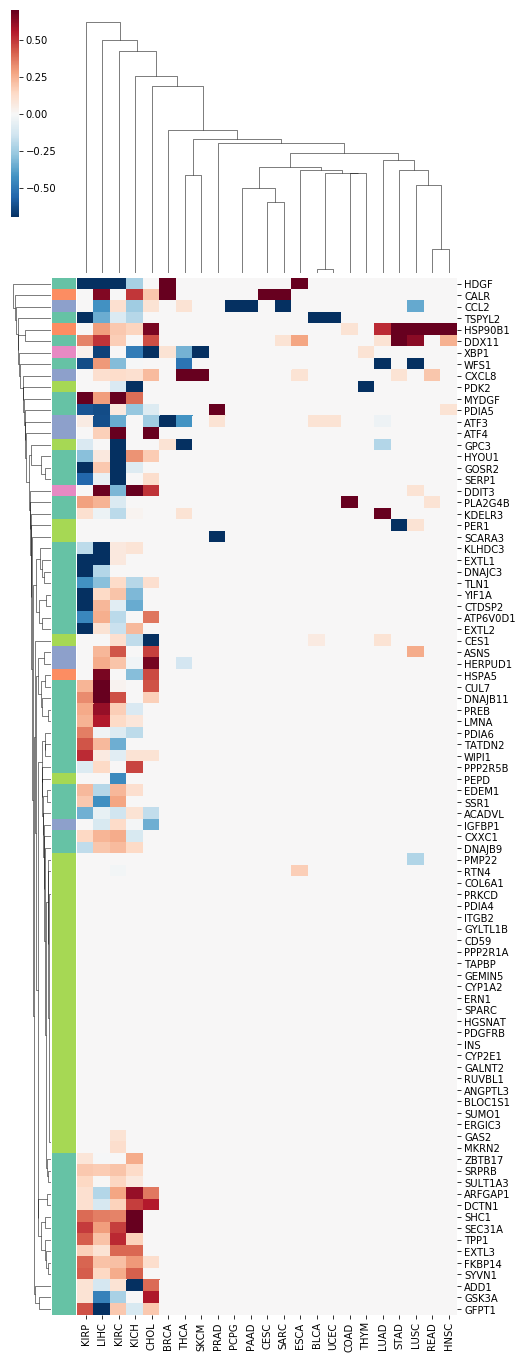

In [29]:
r_color = CreateColorMap(sns.color_palette("Set2")[:5])
sns.clustermap((dfplot.fillna(0)),
               figsize = (8,24),
               center = 0,
               cmap = "RdBu_r",
               row_colors = [r_color[x] for x in dfplot.index.tolist()],
               #method = "ward",
               vmax = .7,
               vmin = -.7,
               )
#plt.savefig("/cellar/users/a53206221/Data/PQ3RO1/fig/update.6.10.2020/Lasso.coef.clustermap.pdf", bbox_inches = "tight")